This is a 5 layers Sequential Convolutional Neural Network for digits recognition trained on MNIST dataset. It was built with keras API (Tensorflow backend) which is the recommended library for tensorflow. Firstly, data preparation (handwritten digits images) then i will focus on the CNN modeling and evaluation.

I achieved 99.671% of accuracy with this CNN trained in 2h30 on a GPU. 
Data for this project can be found [here]('https://www.kaggle.com/c/digit-recognizer/data') on kaggle

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import os, random, gc
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

import tensorflow as tf
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model

sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


In [2]:
def seed_everything(seed=0):
    # To make every process deterministic, thereby, ensure that the experiment is reproducible
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed_everything(2020)

# set to true during development, false during actual training
DEV_RUN = False

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

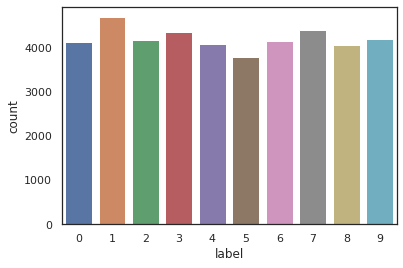

In [3]:
# Load the data

DIR = "/kaggle/input/digit-recognizer/"
train = pd.read_csv(DIR + "train.csv")
# test = pd.read_csv(DIR + "test.csv")

train_y = train["label"]
train_x = train.drop(labels=["label"], axis=1)
del train
gc.collect()

g = sns.countplot(train_y)
train_y.value_counts()

In [4]:
print("Train missing:")
print(train_x.isnull().any().describe(), "\n")
print("There are no missing values in the dataset")

Train missing:
count       784
unique        1
top       False
freq        784
dtype: object 

There are no missing values in the dataset


In [5]:
# Data Normalization
train_x = train_x / 255.0

# Reshape the data
train_x = train_x.values.reshape(-1, 28, 28, 1)

In [6]:
# one hot encode the labels
train_y = to_categorical(train_y, num_classes=10)
train_y

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [7]:
# split into train and validation
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.1, random_state=2020)

The split done above is valid because of size of the dataset (42_000), so a test size of 4200 images is good, and also the fact that the dataset is balanced, so a random split would work fine. If it wasn't balanced, we would have had to set `stratify=True` option in the `train_test_split` function

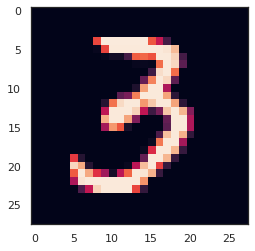

In [8]:
# view one image
g = plt.imshow(train_x[0][:,:,0])

### CNN

In [9]:
if DEV_RUN:
    filter1 = 8
    filter2 = 8
    layer1 = 64
    epochs = 3
    batch_size = 200
else:
    filter1 = 32
    filter2 = 64
    layer1 = 256
    epochs = 40
    batch_size = 200

In [10]:
model = Sequential()
model.add(Conv2D(filters=filter1, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=filter2, kernel_size=(3,3), padding='Same', activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(layer1, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

In [11]:
# Define the optimizer
optimizer = Adam(lr=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [12]:
# # train the model (no data augmentation)
# history = model.fit(train_x, train_y, batch_size=batch_size,
#                     epochs=epochs, validation_data=(val_x, val_y), verbose=1)

In [13]:
# Apply data augmentation to prevent overfitting
datagen = ImageDataGenerator(featurewise_center=False, # set input mean to 0 over the dataset
                             samplewise_center=False, # set each sample mean to 0
                             featurewise_std_normalization=False, # divide inputs by std of the dataset
                             samplewise_std_normalization=False, # divide each input by its std
                             zca_whitening=False, # apply ZCA whitening
                             rotation_range=10, # randomly rotate images in the range
                             zoom_range=0.1, # randomly zoom image
                             width_shift_range=0.1, # randomly shift images horizontally
                             height_shift_range=0.1, # randomly shift images vertically
                             horizontal_flip=False, # randomly flip images
                             vertical_flip=False) # randomly flip images

datagen.fit(train_x)

In [14]:
# train the model
history = model.fit_generator(datagen.flow(train_x, train_y, batch_size=batch_size),
                              epochs=epochs,
                              validation_data=(val_x,val_y),
                              verbose=1,
                              steps_per_epoch=train_x.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction])

Epoch 1/40
189/189 [==============================] - 36s 189ms/step - loss: 0.5909 - accuracy: 0.8062 - val_loss: 0.0836 - val_accuracy: 0.9733
Epoch 2/40
  1/189 [..............................] - ETA: 31s - loss: 0.2172 - accuracy: 0.9100

/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


189/189 [==============================] - 35s 184ms/step - loss: 0.1760 - accuracy: 0.9453 - val_loss: 0.0652 - val_accuracy: 0.9783
Epoch 3/40
189/189 [==============================] - 34s 181ms/step - loss: 0.1287 - accuracy: 0.9601 - val_loss: 0.0521 - val_accuracy: 0.9848
Epoch 4/40
189/189 [==============================] - 35s 183ms/step - loss: 0.1139 - accuracy: 0.9643 - val_loss: 0.0487 - val_accuracy: 0.9855
Epoch 5/40
189/189 [==============================] - 34s 180ms/step - loss: 0.0916 - accuracy: 0.9701 - val_loss: 0.0466 - val_accuracy: 0.9867
Epoch 6/40
189/189 [==============================] - 34s 180ms/step - loss: 0.0841 - accuracy: 0.9730 - val_loss: 0.0390 - val_accuracy: 0.9881
Epoch 7/40
189/189 [==============================] - 35s 183ms/step - loss: 0.0760 - accuracy: 0.9767 - val_loss: 0.0361 - val_accuracy: 0.9893
Epoch 8/40
189/189 [==============================] - 36s 193ms/step - loss: 0.0718 - accuracy: 0.9774 - val_loss: 0.0440 - val_accuracy: 0.9

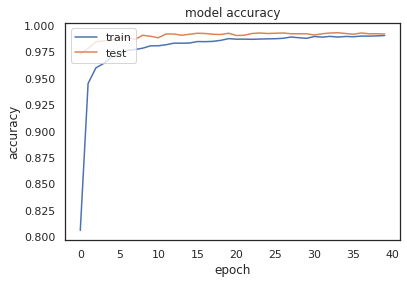

In [15]:
# plot the accuracy curves for training and validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

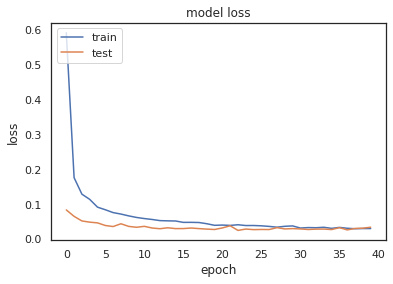

In [16]:
# plot the loss curves for training and validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [17]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [18]:
# predict the values from the validation dataset
val_pred = model.predict(val_x)
val_pred_classes = np.argmax(val_pred, axis=1)
val_true = np.argmax(val_y, axis=1)

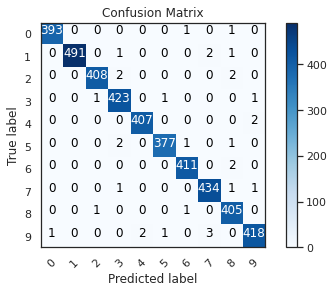

In [19]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(val_true, val_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=range(10))

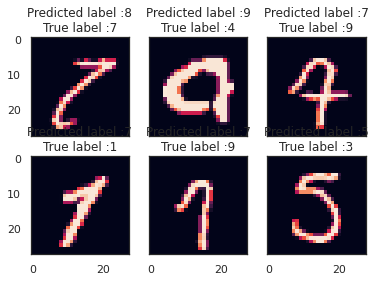

In [20]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (val_pred_classes - val_true != 0)

Y_pred_classes_errors = val_pred_classes[errors]
Y_pred_errors = val_pred[errors]
Y_true_errors = val_true[errors]
X_val_errors = val_x[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [21]:
# save the model to disk
filename = 'digit_recog_model.h5'
model.save(filename)

 
# # load the model from disk
# loaded_model = load_model(filename)
# result = loaded_model.score(X_test, Y_test)
# print(result)